In [130]:
import librosa
import scipy
import glob
import soundfile as sf
from scipy.io import wavfile
import librosa

# Pre

In [141]:
raw_wav_path = '/workspace/LOGS_OUTPUT/server9_nvme1/ASV_LOGS_202102/diarization/ML_May11.wav'
wav, sr = librosa.load(raw_wav_path, sr=16000)


In [142]:
wav = wav[:16000*60]

In [143]:
sf.write('test.wav', wav, sr)

## VAD

In [201]:
import m_mfcc_vad
import matplotlib.pyplot as plt

In [202]:
# raw_wav_path = '/workspace/DATASET/server9_ssd/DIHARD3/eval_wav/DH_EVAL_0001.wav'
raw_wav_path = 'test.wav'
sad_out_path = 'sad.lab'

In [223]:
res = m_mfcc_vad.m_mfcc(raw_wav_path, alpha=0.02, k=0.5, ou=50)

In [224]:
res

[{'start': 0.49, 'end': 1.97},
 {'start': 9.17, 'end': 10.57},
 {'start': 11.81, 'end': 14.47},
 {'start': 14.54, 'end': 14.61},
 {'start': 16.3, 'end': 22.79},
 {'start': 22.84, 'end': 26.37},
 {'start': 33.19, 'end': 37.82},
 {'start': 43.88, 'end': 52.25},
 {'start': 57.54, 'end': 59.49}]

In [225]:
with open(sad_out_path, 'w') as f:
    for i in res:
        line = str(i['start']) + '\t' + str(i['end']) + '\t' + 'speech\n'
        f.write(line)

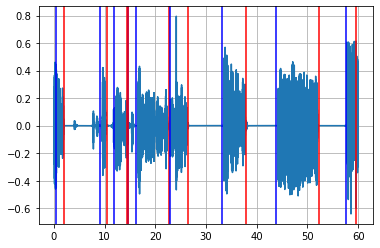

In [226]:
# 音频读取
y, sr = librosa.load(raw_wav_path, sr=16000)
time = [i/sr for i in range(y.shape[0])]
# 时域图
plt.plot(time, y)

for i in range(len(res)):
    plt.axvline(res[i]["start"], c="blue")
    plt.axvline(res[i]["end"], c="red")


plt.grid()

## read wav and segment with oracle vad

In [81]:
# sad_path = '/workspace/DATASET/server9_ssd/DIHARD3/LDC2020E13_Third_DIHARD_Challenge_Evaluation_Data_SCRUBBED/data/sad/DH_EVAL_0001.lab'
# raw_wav_path = '/workspace/DATASET/server9_ssd/DIHARD3/eval_wav/DH_EVAL_0001.wav'

In [227]:
raw_wav_path = 'test.wav'
sad_path = 'sad.lab'

In [228]:
with open(sad_path, 'r') as f:
    sad = f.readlines()
raw_wav = wavfile.read(raw_wav_path)[1]

In [229]:
sad

['0.49\t1.97\tspeech\n',
 '9.17\t10.57\tspeech\n',
 '11.81\t14.47\tspeech\n',
 '14.54\t14.61\tspeech\n',
 '16.3\t22.79\tspeech\n',
 '22.84\t26.37\tspeech\n',
 '33.19\t37.82\tspeech\n',
 '43.88\t52.25\tspeech\n',
 '57.54\t59.49\tspeech\n']

In [230]:
perspk_dict_tmpinsample = {}
sample_len = len(raw_wav)
start, end = None, None

for count, j in enumerate(sad):
    start = int(float(j.split('\t')[0]) * 16000)
    if end is not None:
        perspk_dict_tmpinsample[str(end)+'.'+str(start)] = 'silence'
    end = int(float(j.split('\t')[1]) * 16000)
    perspk_dict_tmpinsample[str(start)+'.'+str(min(end, sample_len))] = 'unknown'
    if end >= sample_len:
        break

if end < sample_len:
    perspk_dict_tmpinsample[str(end)+'.'+str(sample_len)] = 'silence'


In [231]:
perspk_dict_tmpinsample

{'7840.31520': 'unknown',
 '31520.146720': 'silence',
 '146720.169120': 'unknown',
 '169120.188960': 'silence',
 '188960.231520': 'unknown',
 '231520.232640': 'silence',
 '232640.233760': 'unknown',
 '233760.260800': 'silence',
 '260800.364640': 'unknown',
 '364640.365440': 'silence',
 '365440.421920': 'unknown',
 '421920.531040': 'silence',
 '531040.605120': 'unknown',
 '605120.702080': 'silence',
 '702080.836000': 'unknown',
 '836000.920640': 'silence',
 '920640.951840': 'unknown',
 '951840.960000': 'silence'}

## segment to 1.5s

In [232]:
seg_len = int(1.5 * 16000)
seg_hop = int(0.75 * 16000)

In [233]:
seg_len

24000

In [234]:
seg_hop

12000

In [235]:
perspk_dict_tmpinsample

{'7840.31520': 'unknown',
 '31520.146720': 'silence',
 '146720.169120': 'unknown',
 '169120.188960': 'silence',
 '188960.231520': 'unknown',
 '231520.232640': 'silence',
 '232640.233760': 'unknown',
 '233760.260800': 'silence',
 '260800.364640': 'unknown',
 '364640.365440': 'silence',
 '365440.421920': 'unknown',
 '421920.531040': 'silence',
 '531040.605120': 'unknown',
 '605120.702080': 'silence',
 '702080.836000': 'unknown',
 '836000.920640': 'silence',
 '920640.951840': 'unknown',
 '951840.960000': 'silence'}

In [236]:
answer_dict_tmpinsample2 = {}

# perspk_dict_tmpinsample = answer_dict_tmpinsample[i]
perspk_dict_tmpinsample_seg = {}
for j in perspk_dict_tmpinsample:
    if perspk_dict_tmpinsample[j] == 'unknown':
        start, end = j.split('.')
        start, end = int(start), int(end)
        if (end - start) <= seg_len:
            perspk_dict_tmpinsample_seg[str(start)+'.'+str(end)] = 'unknown'
        else:
            start_tmp = start
            end_tmp = start + seg_len
            assert end_tmp < end
            while(True):
                if (end_tmp+seg_hop) > end:
                    end_tmp = end                    
                    perspk_dict_tmpinsample_seg[str(start_tmp)+'.'+str(end_tmp)] = 'unknown'
                    print(end_tmp-start_tmp)
                    break
                else:
                    perspk_dict_tmpinsample_seg[str(start_tmp)+'.'+str(end_tmp)] = 'unknown'
                    start_tmp = start_tmp + seg_hop
                    end_tmp = end_tmp + seg_hop
                    print(end_tmp-start_tmp)
    elif perspk_dict_tmpinsample[j] == 'silence':
        start, end = j.split('.')
        start, end = int(start), int(end)
        perspk_dict_tmpinsample_seg[str(start)+'.'+str(end)] = 'silence'
    else:
        raise Exception

24000
30560
24000
24000
24000
24000
24000
24000
31840
24000
24000
32480
24000
24000
24000
24000
26080
24000
24000
24000
24000
24000
24000
24000
24000
24000
25920
31200


In [237]:
perspk_dict_tmpinsample_seg

{'7840.31520': 'unknown',
 '31520.146720': 'silence',
 '146720.169120': 'unknown',
 '169120.188960': 'silence',
 '188960.212960': 'unknown',
 '200960.231520': 'unknown',
 '231520.232640': 'silence',
 '232640.233760': 'unknown',
 '233760.260800': 'silence',
 '260800.284800': 'unknown',
 '272800.296800': 'unknown',
 '284800.308800': 'unknown',
 '296800.320800': 'unknown',
 '308800.332800': 'unknown',
 '320800.344800': 'unknown',
 '332800.364640': 'unknown',
 '364640.365440': 'silence',
 '365440.389440': 'unknown',
 '377440.401440': 'unknown',
 '389440.421920': 'unknown',
 '421920.531040': 'silence',
 '531040.555040': 'unknown',
 '543040.567040': 'unknown',
 '555040.579040': 'unknown',
 '567040.591040': 'unknown',
 '579040.605120': 'unknown',
 '605120.702080': 'silence',
 '702080.726080': 'unknown',
 '714080.738080': 'unknown',
 '726080.750080': 'unknown',
 '738080.762080': 'unknown',
 '750080.774080': 'unknown',
 '762080.786080': 'unknown',
 '774080.798080': 'unknown',
 '786080.810080': 

In [238]:
seg_count = []

dic = perspk_dict_tmpinsample_seg
count = 0
for j in dic:
    if dic[j] == 'unknown':
        count += 1
seg_count.append(count)

In [239]:
max(seg_count)

31

In [240]:
min(seg_count)

31

## extract embs

In [241]:
import sys
import os
import importlib
import torch
import numpy
import torch.nn.functional as F

In [242]:
sys.path.append('/workspace/GREAT_ASV_system/train_dist')

In [243]:
os.environ['CUDA_VISIBLE_DEVICES'] = "3"

In [128]:
# from DatasetLoader import loadWAV

In [244]:
SpeakerNetModel = importlib.import_module('models.'+'EPACA-TDNN').__getattribute__('MainModel')

In [245]:
# EPACA-TDNN
S = SpeakerNetModel(n_mels=40, nOut=192, spec_aug=False)

EPACA-TDNN.py, Embedding size is 192, Channels 1024, Spec_aug False.


In [246]:
model_path = '/workspace/LOGS_OUTPUT/server9_nvme1/ASV_LOGS_202102/train_logs_201120/sdsv21_full_pretrain/model/model000000024.model'

In [247]:
S.cuda()

ECAPA_TDNN(
  (instancenorm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (torchfb): Sequential(
    (0): PreEmphasis()
    (1): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (layer1): Conv1dReluBn(
    (conv): Conv1d(40, 1024, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (2): Conv1d(128, 128, kernel_size=(3,), 

In [248]:
loaded_state = torch.load(model_path, map_location="cuda:0")

In [249]:
self_state = S.state_dict()

for name, param in loaded_state['model'].items():
    origname = name
    if name not in self_state:
        name = name.replace("__S__.", "")

        if name not in self_state:
            print("#%s is not in the model."%origname)
            continue

    if self_state[name].size() != loaded_state['model'][origname].size():
        print("#Wrong parameter length: %s, model: %s, loaded: %s"%(origname, self_state[name].size(), loaded_state[origname].size()))
        continue

    self_state[name].copy_(param)

#__L__.W is not in the model.


In [250]:
S.eval()

ECAPA_TDNN(
  (instancenorm): InstanceNorm1d(40, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (torchfb): Sequential(
    (0): PreEmphasis()
    (1): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (layer1): Conv1dReluBn(
    (conv): Conv1d(40, 1024, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(1024, 1024, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
        (2): Conv1d(128, 128, kernel_size=(3,), 

In [251]:
def audio2emb(audio):
    audiosize = audio.shape[0]
    max_audio = seg_len
    if audiosize <= max_audio:
        shortage    = max_audio - audiosize + 1 
        audio       = numpy.pad(audio, (0, shortage), 'wrap')
    audio = audio[None, :].astype(numpy.float)

    inp1 = torch.FloatTensor(audio).cuda()

    ref_feat = S.forward(inp1).detach().cpu()
    return ref_feat

In [252]:
spks_matind2time = {}

In [253]:
perspk_matind2time = {}
count = 0
for j in perspk_dict_tmpinsample_seg:
    if perspk_dict_tmpinsample_seg[j] == 'unknown':
        perspk_matind2time[count] = j
        count += 1
print(count)

31


In [254]:
perspk_matind2time

{0: '7840.31520',
 1: '146720.169120',
 2: '188960.212960',
 3: '200960.231520',
 4: '232640.233760',
 5: '260800.284800',
 6: '272800.296800',
 7: '284800.308800',
 8: '296800.320800',
 9: '308800.332800',
 10: '320800.344800',
 11: '332800.364640',
 12: '365440.389440',
 13: '377440.401440',
 14: '389440.421920',
 15: '531040.555040',
 16: '543040.567040',
 17: '555040.579040',
 18: '567040.591040',
 19: '579040.605120',
 20: '702080.726080',
 21: '714080.738080',
 22: '726080.750080',
 23: '738080.762080',
 24: '750080.774080',
 25: '762080.786080',
 26: '774080.798080',
 27: '786080.810080',
 28: '798080.822080',
 29: '810080.836000',
 30: '920640.951840'}

In [255]:
matind2time = perspk_matind2time
whole_wav = raw_wav
embs = None
for j in range(len(matind2time)):
    start, end = matind2time[j].split('.')
    start, end = int(start), int(end)
    if embs is not None:
        embs = torch.cat([embs, audio2emb(whole_wav[start:end])], dim=0)
    else:
        embs = audio2emb(whole_wav[start:end])

embs_n = F.normalize(embs, p=2, dim=1)
similarity = embs_n.mm(embs_n.T)
similarity = similarity.numpy()

In [256]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

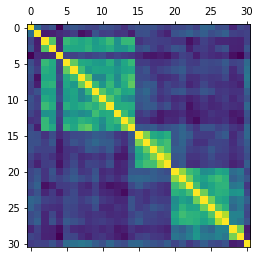

In [257]:
plt.matshow(similarity)

## Spectral Clustering

In [258]:
from sklearn.cluster import KMeans

In [265]:
def SC(inp_matrix):
    # 1 . Construct S and set diagonal elements to 0.
    for i in range(inp_matrix.shape[0]):
        inp_matrix[i][i] = 0.0
    # 2 . Compute Laplacian matrix L and perform normalization
    S = inp_matrix
    D = numpy.diag(numpy.sum(S, axis=1))
    L = D - S
    invsqrtD = numpy.diag(1.0 / (numpy.sum(S, axis=1) ** (0.5)))
    L_norm = numpy.dot(numpy.dot(invsqrtD, L), invsqrtD)
    # 3 . Compute eigenvalues and eigenvectors of L norm
    lam, H = numpy.linalg.eig(L_norm)
    
    # ADDED!
    try:
        lam = lam.real
        H = H.real
    except:
        pass
    
    # 4 . Take the k smallest eigenvalues
    TH = 0.99
#    TH = 0.75
#     TH = 0.85
    
    sort_index = numpy.argsort(lam)
    eig_vecs = []
    count = 0
    for i in sort_index:
        if (lam[i] > TH) and (count >= 2):
            break
        else:
            eig_vecs.append(H[:, i])
            count += 1

    for count, i in enumerate(eig_vecs):
        if count == 0:
            P = i[:, None]
        else:
            P = numpy.append(P, i[:, None], axis=1)
    # 5. Cluster row vectors y 1 , y 2 , ...y n of P to k classes by the K-means algorithm.            
    sp_kmeans = KMeans(n_clusters=P.shape[1]).fit(P)
    return sp_kmeans.labels_

In [259]:
# 1 . Construct S and set diagonal elements to 0.
for i in range(inp_matrix.shape[0]):
    inp_matrix[i][i] = 0.0
# 2 . Compute Laplacian matrix L and perform normalization
S = inp_matrix
D = numpy.diag(numpy.sum(S, axis=1))
L = D - S
invsqrtD = numpy.diag(1.0 / (numpy.sum(S, axis=1) ** (0.5)))
L_norm = numpy.dot(numpy.dot(invsqrtD, L), invsqrtD)
# 3 . Compute eigenvalues and eigenvectors of L norm
lam, H = numpy.linalg.eig(L_norm)

# ADDED!
try:
    lam = lam.real
    H = H.real
except:
    pass

# 4 . Take the k smallest eigenvalues
TH = 0.98
#    TH = 0.75
#     TH = 0.85

sort_index = numpy.argsort(lam)
eig_vecs = []
count = 0
for i in sort_index:
    if (lam[i] > TH) and (count >= 2):
        break
    else:
        eig_vecs.append(H[:, i])
        count += 1

for count, i in enumerate(eig_vecs):
    if count == 0:
        P = i[:, None]
    else:
        P = numpy.append(P, i[:, None], axis=1)
# 5. Cluster row vectors y 1 , y 2 , ...y n of P to k classes by the K-means algorithm.            
sp_kmeans = KMeans(n_clusters=P.shape[1]).fit(P)

In [266]:
lam

array([-1.3657085e-08,  9.4425428e-01,  9.7929668e-01,  1.0038573e+00,
        1.0226271e+00,  1.0240058e+00,  1.0275466e+00,  1.0289078e+00,
        1.0329269e+00,  1.0359396e+00,  1.0371202e+00,  1.0379312e+00,
        1.0397278e+00,  1.0411643e+00,  1.0423452e+00,  1.0439607e+00,
        1.0446990e+00,  1.0465904e+00,  1.0467386e+00,  1.0476657e+00,
        1.0484651e+00,  1.0552598e+00,  1.0503857e+00,  1.0511792e+00,
        1.0515214e+00,  1.0532022e+00,  1.0538632e+00,  1.0544771e+00,
        1.0543410e+00], dtype=float32)

In [267]:
inp_matrix = (similarity + 1.0) / 2.0
spk_clustering_result = SC(inp_matrix)

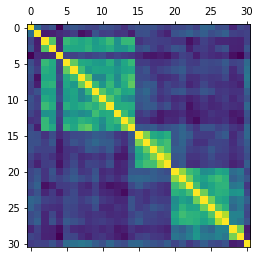

In [268]:
plt.matshow(similarity)

In [269]:
spk_clustering_result

array([1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2], dtype=int32)

## combine detection result

In [270]:
perspk_dict_tmpinsample_seg

{'7840.31520': 'unknown',
 '31520.146720': 'silence',
 '146720.169120': 'unknown',
 '169120.188960': 'silence',
 '188960.212960': 'unknown',
 '200960.231520': 'unknown',
 '231520.232640': 'silence',
 '232640.233760': 'unknown',
 '233760.260800': 'silence',
 '260800.284800': 'unknown',
 '272800.296800': 'unknown',
 '284800.308800': 'unknown',
 '296800.320800': 'unknown',
 '308800.332800': 'unknown',
 '320800.344800': 'unknown',
 '332800.364640': 'unknown',
 '364640.365440': 'silence',
 '365440.389440': 'unknown',
 '377440.401440': 'unknown',
 '389440.421920': 'unknown',
 '421920.531040': 'silence',
 '531040.555040': 'unknown',
 '543040.567040': 'unknown',
 '555040.579040': 'unknown',
 '567040.591040': 'unknown',
 '579040.605120': 'unknown',
 '605120.702080': 'silence',
 '702080.726080': 'unknown',
 '714080.738080': 'unknown',
 '726080.750080': 'unknown',
 '738080.762080': 'unknown',
 '750080.774080': 'unknown',
 '762080.786080': 'unknown',
 '774080.798080': 'unknown',
 '786080.810080': 

In [271]:
tmpinsample2 = perspk_dict_tmpinsample_seg
matind2time = perspk_matind2time
clustering_result = spk_clustering_result

assert len(matind2time) == len(clustering_result)
for j in matind2time:
    assert matind2time[j] in tmpinsample2.keys()
    tmpinsample2[matind2time[j]] = 'speaker'+str(clustering_result[j]+1)
for k in tmpinsample2:
    assert tmpinsample2[k] != 'unknown'


In [272]:
whole_start = list(tmpinsample2.keys())[0].split('.')[0]
if whole_start != '0':
    tmpinsample2['0.'+whole_start] = 'silence'

In [273]:
tmpinsample2

{'7840.31520': 'speaker2',
 '31520.146720': 'silence',
 '146720.169120': 'speaker2',
 '169120.188960': 'silence',
 '188960.212960': 'speaker3',
 '200960.231520': 'speaker3',
 '231520.232640': 'silence',
 '232640.233760': 'speaker3',
 '233760.260800': 'silence',
 '260800.284800': 'speaker3',
 '272800.296800': 'speaker3',
 '284800.308800': 'speaker3',
 '296800.320800': 'speaker3',
 '308800.332800': 'speaker3',
 '320800.344800': 'speaker3',
 '332800.364640': 'speaker3',
 '364640.365440': 'silence',
 '365440.389440': 'speaker3',
 '377440.401440': 'speaker3',
 '389440.421920': 'speaker3',
 '421920.531040': 'silence',
 '531040.555040': 'speaker1',
 '543040.567040': 'speaker1',
 '555040.579040': 'speaker1',
 '567040.591040': 'speaker1',
 '579040.605120': 'speaker1',
 '605120.702080': 'silence',
 '702080.726080': 'speaker2',
 '714080.738080': 'speaker2',
 '726080.750080': 'speaker2',
 '738080.762080': 'speaker2',
 '750080.774080': 'speaker2',
 '762080.786080': 'speaker2',
 '774080.798080': 'sp

# FINISH

In [274]:
for i in tmpinsample2:
    print(float(i.split('.')[0])/16000, float(i.split('.')[1])/16000, tmpinsample2[i])

0.49 1.97 speaker2
1.97 9.17 silence
9.17 10.57 speaker2
10.57 11.81 silence
11.81 13.31 speaker3
12.56 14.47 speaker3
14.47 14.54 silence
14.54 14.61 speaker3
14.61 16.3 silence
16.3 17.8 speaker3
17.05 18.55 speaker3
17.8 19.3 speaker3
18.55 20.05 speaker3
19.3 20.8 speaker3
20.05 21.55 speaker3
20.8 22.79 speaker3
22.79 22.84 silence
22.84 24.34 speaker3
23.59 25.09 speaker3
24.34 26.37 speaker3
26.37 33.19 silence
33.19 34.69 speaker1
33.94 35.44 speaker1
34.69 36.19 speaker1
35.44 36.94 speaker1
36.19 37.82 speaker1
37.82 43.88 silence
43.88 45.38 speaker2
44.63 46.13 speaker2
45.38 46.88 speaker2
46.13 47.63 speaker2
46.88 48.38 speaker2
47.63 49.13 speaker2
48.38 49.88 speaker2
49.13 50.63 speaker2
49.88 51.38 speaker2
50.63 52.25 speaker2
52.25 57.54 silence
57.54 59.49 speaker3
59.49 60.0 silence
0.0 0.49 silence
